In [ ]:
import random
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [ ]:
!gdown --id 1-GnWpEkyjLljI_UwPA47j6kgtzLYamFQ

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-GnWpEkyjLljI_UwPA47j6kgtzLYamFQ
To: /content/parallel_data_SEM_CHILDES_3.csv
100% 71.7M/71.7M [00:01<00:00, 59.4MB/s]


In [ ]:
childes = pd.read_csv("parallel_data_SEM_CHILDES_3.csv")

In [ ]:
childes

,english,bliss
0,it's a chicken,14960 12639 8521 13165
1,what is that,18231 12639 16482
2,it's a woof,14960 12639 8521 -999999
3,is that a hat,12639 16482 8521 14682
4,oh look at that,16747 12591 16482
...,...,...
961773,it was something funny two things,14960 12639 12400 14414 8512 17717
961774,two things that were funny,8512 17717 16482 12639 14414
961775,nber two he bendeded a camp,-999999 8512 14687 -999999 8521 13112
961776,went into someone's face,14449 25896 12399 12639 14138


In [ ]:

def percent_unidentified(x):
    d = x.strip().split(" ");
    den = len(d)
    num = d.count("-999999");
    return num/den

def clean_data(df):
    df.dropna(inplace = True)
    df["percent_unidentified"] = df["bliss"].apply(percent_unidentified)
    df = df[(df['percent_unidentified']<0.1)]
    # df = df.loc[df['english'].drop_duplicates(keep = "first").index]
    df["bliss"] = df["bliss"].apply(lambda x: x.strip())
    df = df.sample(frac = 1, random_state=43).reset_index(drop=True)

    return df

data  = clean_data(childes)



<ipython-input-20-7d6af5a41fb7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bliss"] = df["bliss"].apply(lambda x: x.strip())


In [ ]:
data

,english,bliss,percent_unidentified
0,too small isn't it,12374 15221 12639 15733 14960,0.0
1,you got some cream cheese,18465 14435 17207 13605 13157,0.0
2,I'm gonna put the light on,14916 12639 14449 17739 16440 17700 25336 12324,0.0
3,you want the old spot,18465 24834 17700 15915 17236,0.0
4,"this is a microphone , and that's a microphone","17720 12639 8521 23902 , 12374 16482 12639 852...",0.0
...,...,...,...
584618,you don't want the whole thing or nothing do you,18465 13860 15733 24834 17700 12360 17717 1592...,0.0
584619,now you're using the screwdriver,15736 18465 12639 17991 17700 16740,0.0
584620,goes through where,14449 17724 18237,0.0
584621,this just goes on like this,17720 12363 14449 12324 16984 17720,0.0


In [ ]:
len(data)


584623

In [ ]:
text_pairs = [(data["bliss"][i], "[start] " + data["english"][i] + " [end]") for i in range(len(data))]


In [ ]:
# random.shuffle(text_pairs)
num_val_samples = int(0.1 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

584623 total pairs
467699 training pairs
58462 validation pairs
58462 test pairs


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3135745616711692505
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13361029481338562113
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
%%time
import re
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

# @tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


inp_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
out_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_inp_texts = [pair[0] for pair in train_pairs]
train_out_texts = [pair[1] for pair in train_pairs]
inp_vectorization.adapt(train_inp_texts)
out_vectorization.adapt(train_out_texts)

In [ ]:

def format_dataset(inp_lang, out_lang):
    inpv = inp_vectorization(inp_lang)
    outv = out_vectorization(out_lang)
    return ({"encoder_inputs": inpv, "decoder_inputs": outv[:, :-1],}, outv[:, 1:])


def make_dataset(pairs):
    inp_texts, out_texts = zip(*pairs)
    inp_texts = list(inp_texts)
    out_texts = list(out_texts)
    dataset = tf.data.Dataset.from_tensor_slices((inp_texts, out_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [ ]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 8


vocab_size = 15000
sequence_length = 20
batch_size = 64

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

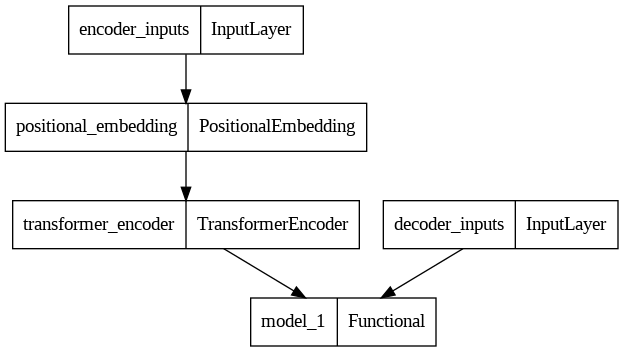

In [ ]:
tf.keras.utils.plot_model(transformer)

In [ ]:
## TRAIN

epochs = 10  # This should be at least 30 for convergence
filepath = "/content/drive/MyDrive/btp/bliss_to_english-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='auto')

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=checkpoint)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# vectorize_layer_model = tf.keras.models.Sequential()
# vectorize_layer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
# vectorize_layer_model.add(inp_vectorization)
# vectorize_layer_model.summary()
# vectorize_layer_model.save('inp_vectorization_layer', save_format="h5")

# vectorize_layer_model = tf.keras.models.Sequential()
# vectorize_layer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
# vectorize_layer_model.add(out_vectorization)
# vectorize_layer_model.summary()
# vectorize_layer_model.save('out_vectorization_layer.hdf5', save_format="h5")



In [ ]:
#LOAD SAVED MODEL

import re
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

inp_vectorization_ = tf.keras.models.load_model("/content/drive/MyDrive/btp/models/inp_vectorization_layer").layers[0]
out_vectorization_ = tf.keras.models.load_model("/content/drive/MyDrive/btp/models/out_vectorization_layer").layers[0]


In [17]:
!python --version

Python 3.9.16


In [ ]:
#LOAD SAVED MODEL

from tensorflow import keras
transformer = keras.models.load_model('/content/drive/MyDrive/btp/models/bliss_to_english-10-0.89.hdf5', custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder':TransformerEncoder, 'TransformerDecoder':TransformerDecoder})

In [ ]:
out_vocab = out_vectorization.get_vocabulary()
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = inp_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = out_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_inp_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_pairs)
    translated = decode_sequence(input_sentence[0])
    print(input_sentence)
    print("prediction :", translated)

In [ ]:
out_vocab = out_vectorization_.get_vocabulary()
out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = inp_vectorization_([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = out_vectorization_([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = out_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
decode_sequence('14916 24732 18465 14449')

'[start] i let you go [end]'

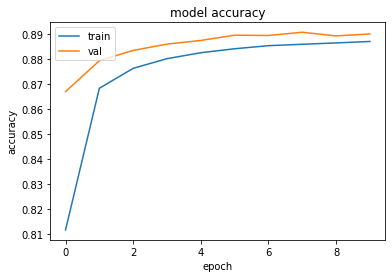

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

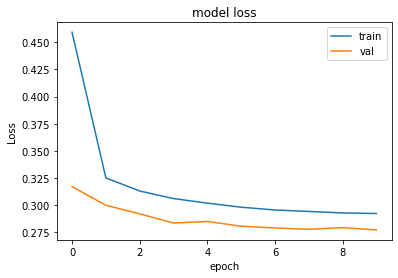

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## METEOR Score

In [ ]:
references_childes = list(childes["english"].apply(lambda x: x.strip().replace("'", "").replace('"', '')))

In [ ]:
references_childes

NameError: ignored

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.1 MB/s eta 0:00:00


In [ ]:
%%time
import evaluate
meteor = evaluate.load('meteor')
predictions = ["Its a nice dog"]
references = ["this is a dog", "its a dog", "dog it is", "a dog it is"]
results = meteor.compute(predictions=predictions, references=[references])
x = (round(results['meteor'], 2))
print(x)

0.82
CPU times: user 55.6 ms, sys: 3.88 ms, total: 59.4 ms
Wall time: 1.86 s


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
x


0.82

In [ ]:
nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)

1.0

In [ ]:
import nltk

hypothesis = ['It', 'is', 'a', 'cat']
reference = ['It', 'is', 'a', 'cat']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

1.0


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'this is a dog'.split(),
    'it is dog'.split(),
    'dog it is'.split(),
    'a dog, it is'.split() 
]
candidate = 'it is dog'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate )))

candidate = 'it is a dog'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))

BLEU score -> 1.2213386697554703e-77
BLEU score -> 1.0270193092081295e-77


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
results = meteor.compute(predictions=["it is dog"], references=[["this is a dog", "it is dog", "dog it is", "a dog, it is"]])
print(round(results['meteor'], 2))


ValueError: ignored

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'this is a dog'.split(),
    'it is dog'.split(),
    'dog it is'.split(),
    'a dog, it is'.split() 
]
candidate = 'it is a dog'.split()

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))


score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

Individual 1-gram: 1.000000
Individual 2-gram: 1.000000
Individual 3-gram: 0.500000
Individual 4-gram: 0.000000
1.0270193092081295e-77


In [ ]:
sentence_bleu(reference, candidate)


1.0270193092081295e-77

## Change Tense

In [ ]:
!pip install pattern

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 KB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 101.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.4/348.4 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 KB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 29.2 MB/s eta 0:00:00
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332722 sha256=74beb4

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import string

from pattern.en import conjugate, PAST, PRESENT, SINGULAR, PLURAL
import spacy
from spacy.symbols import NOUN



SUBJ_DEPS = {'agent', 'csubj', 'csubjpass', 'expl', 'nsubj', 'nsubjpass'}

nlp = spacy.load('en_core_web_sm')


def _get_conjuncts(tok):
    """
    Return conjunct dependents of the leftmost conjunct in a coordinated phrase,
    e.g. "Burton, [Dan], and [Josh] ...".
    """
    return [right for right in tok.rights
            if right.dep_ == 'conj']


def is_plural_noun(token):
    """
    Returns True if token is a plural noun, False otherwise.
    Args:
        token (``spacy.Token``): parent document must have POS information
    Returns:
        bool
    """
    if token.doc.has_annotation("TAG") is False:
        raise ValueError('token is not POS-tagged')
    return True if token.pos == NOUN and token.lemma != token.lower else False


def get_subjects_of_verb(verb):
    if verb.dep_ == "aux" and list(verb.ancestors):
        return get_subjects_of_verb(list(verb.ancestors)[0])
    """Return all subjects of a verb according to the dependency parse."""
    subjs = [tok for tok in verb.lefts
             if tok.dep_ in SUBJ_DEPS]
    # get additional conjunct subjects
    subjs.extend(tok for subj in subjs for tok in _get_conjuncts(subj))
    if not len(subjs):
        ancestors = list(verb.ancestors)
        if len(ancestors) > 0:
            return get_subjects_of_verb(ancestors[0])
    return subjs


def is_plural_verb(token):
    if token.doc.has_annotation("TAG") is False:
        raise ValueError('token is not POS-tagged')
    subjects = get_subjects_of_verb(token)
    if not len(subjects):
        return False
    plural_score = sum([is_plural_noun(x) for x in subjects])/len(subjects)

    return plural_score > .5

def preserve_caps(word, newWord):
    """Returns newWord, capitalizing it if word is capitalized."""
    if word[0] >= 'A' and word[0] <= 'Z':
        newWord = newWord.capitalize()
    return newWord

def change_tense(text, to_tense, nlp=nlp):
    """Change the tense of text.
    Args:
        text (str): text to change.
        to_tense (str): 'present','past', or 'future'
        npl (SpaCy model, optional):
    Returns:
        str: changed text.
    """
    tense_lookup = {'future': 'inf', 'present': PRESENT, 'past': PAST}
    tense = tense_lookup[to_tense]

    doc = nlp(text)

    out = list()
    out.append(doc[0].text)
    words = []
    for word in doc:
        words.append(word)
        if len(words) == 1:
            continue
        if (words[-2].text == 'will' and words[-2].tag_ == 'MD' and words[-1].tag_ == 'VB') or \
                        words[-1].tag_ in ('VBD', 'VBP', 'VBZ', 'VBN') or \
                (not words[-2].text in ('to', 'not') and words[-1].tag_ == 'VB'):

            if words[-2].text in ('were', 'am', 'is', 'are', 'was') or\
                    (words[-2].text == 'be' and len(words) > 2 and words[-3].text == 'will'):
                this_tense = tense_lookup['past']
            else:
                this_tense = tense

            subjects = [x.text for x in get_subjects_of_verb(words[-1])]
            if ('I' in subjects) or ('we' in subjects) or ('We' in subjects):
                person = 1
            elif ('you' in subjects) or ('You' in subjects):
                person = 2
            else:
                person = 3
            if is_plural_verb(words[-1]):
                number = PLURAL
            else:
                number = SINGULAR
            if (words[-2].text == 'will' and words[-2].tag_ == 'MD') or words[-2].text == 'had':
                out.pop(-1)
            if to_tense == 'future':
                if not (out[-1] == 'will' or out[-1] == 'be'):
                    out.append('will')
                # handle will as a noun in future tense
                if words[-2].text == 'will' and words[-2].tag_ == 'NN':
                    out.append('will')
            #if word_pair[0].dep_ == 'auxpass':
            oldWord = words[-1].text
            out.append(preserve_caps(oldWord, conjugate(oldWord, tense=this_tense, person=person, number=number)))
        else:
            out.append(words[-1].text)

        # negation
        if words[-2].text + words[-1].text in ('didnot', 'donot', 'willnot', "didn't", "don't", "won't"):
            if tense == PAST:
                out[-2] = 'did'
            elif tense == PRESENT:
                out[-2] = 'do'
            else:
                out.pop(-2)

        # future perfect, and progressives, but ignore for "I will have cookies"
        if words[-1].text in ('have', 'has') and len(list(words[-1].ancestors)) and words[-1].dep_ == 'aux':
            out.pop(-1)

    text_out = ' '.join(out)

    # Remove spaces before/after punctuation:
    for char in string.punctuation:
        if char in """(<['""":
            text_out = text_out.replace(char+' ', char)
        else:
            text_out = text_out.replace(' '+char, char)

    for char in ["-", "“", "‘"]:
        text_out = text_out.replace(char+' ', char)
    for char in ["…", "”", "'s", "n't"]:
        text_out = text_out.replace(' '+char, char)

    return text_out


In [ ]:
change_tense("'White rabbits with pink eyes runs close by her.'", "future")

"'White rabbits with pink eyes will run close by her. '"